# Includable Transactions per Block

In [1]:
import pandas as pd
import numpy as np
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Process the "finalized" master file
Note you only need to run the filtering cell once. Once you have stored filtered_finalized_txns.csv.gz, you can skip to the next cell to load it in

In [2]:
# DATA FILTERING - 
# You only need to run this cell once. After you create the filtered_finalized_txns.csv.gz file, you can skip this cell.

#~~~~~~~~~~~~~~~~~~~~~~~~~~
# SET PATH to master.csv.gz
#~~~~~~~~~~~~~~~~~~~~~~~~~~
master_df = '/Volumes/Seagate/misc/master.csv.gz'
df = pd.read_csv(master_df, compression='gzip', sep='\t')


# drop private transactions
df = df[df['timepending'] > 0]

# drop non finalized events and duplicate confirmations (keep the first one)
df = df[(df['status'] == 'confirmed') | (df['status'] == 'failed')]
df = df.drop_duplicates(subset=['hash'], keep='first')

# convert these 2 columns to integers
df['blockspending'] = df['blockspending'].astype(int)
df['maxfeepergas'] = df['maxfeepergas'].astype(int)

# drop the rows with the highest, top 1% of 'gasused' (extreme outliers)
df = df[df['gasused'] < df['gasused'].quantile(0.99)]

df = df.reset_index(drop=True)

# store to smaller file
df.to_csv('filtered_finalized_txns.csv.gz', compression='gzip', sep='\t', index=False)

## Load in the filtered df
I like to restart my notebook after filering and load in the new, lighter filtered_finalized_txns.csv.gz file to clear up memory. 

In [2]:
# Load in the dataset
df = pd.read_csv('filtered_finalized_txns.csv.gz', compression='gzip', sep='\t')

# 2. Get basefeepergas per curblocknumber

curblocknumber[i] has basefeepergas[i] 

In [3]:
# You only need to run this cell one time to create the pickle. After you've create the pickle, you can skip this cell.

# Get a list of curblocknumber, basefeepergas
curblocknumber = df['curblocknumber'].values
basefeepergas = df['basefeepergas'].values

# zip together the two arrays and remove duplicates
zipped = list(zip(curblocknumber, basefeepergas))
zipped = list(set(zipped))

# sort zipped by curblocknumber
zipped.sort(key=lambda x: x[0])

curblocknumber, basefeepergas = zip(*zipped)

# Check if curblocknumber is monotonic increasing and sequential
curblocknumber = np.array(curblocknumber)
print("Is curblocknumber monotonic increasing?", np.all(np.diff(curblocknumber) > 0))
print("Is curblocknumber sequential (no gaps)?", np.all(np.diff(curblocknumber) == 1))

# store curblocknumber and basefeepergas in pickle file
with open('curblocknumber_basefeepergas.pickle', 'wb') as f:
    pickle.dump((curblocknumber, basefeepergas), f)

Is curblocknumber monotonic increasing? True
Is curblocknumber sequential (no gaps)? True


#### Read in the curblocknumber and basefeepergas

In [3]:
# Load the lists of curblocknumber, basefeepergas
with open('curblocknumber_basefeepergas.pickle', 'rb') as f:
    curblocknumber, basefeepergas = pickle.load(f)

curblocknumber = np.array(curblocknumber)
basefeepergas = np.array(basefeepergas)

## Initialization

In [4]:
# Includable Txns per Block 

# initliaze an np array of zeros of the length of curblocknumber
# this will be the GPB array where blocknumber = index + offset
gpb  = np.zeros(len(curblocknumber))    # gas per block (uses column 'gas')
gupb = np.zeros(len(curblocknumber))    # gas used per block (uses column 'gasused')
txns = np.zeros(len(curblocknumber))    # includable transactions per block (increases whenever a transaction is considered includable (MFPG >= BFPB))
offset = curblocknumber[0]

In [6]:
# check if the values in 'hash' are unique
print("Are the values in 'hash' unique?", len(df['hash']) == len(set(df['hash'])))

Are the values in 'hash' unique? True


# 3. Process Data

In [6]:
df_len = len(df)

for index, row in df.iterrows():

    if index % 1000 == 0:
        print("\rcheckpoint at row {} of {}".format(index, df_len), end="")

    # get the last block (the block when the transaction is finalized (confirmed/failed))
    # note that the rows are finalized status so the 'curblocknumber' is the block that the transaction is included in. 
    last_block = row['curblocknumber']
    last_block_index = last_block - offset

    # get the first block (the block when the transaction is first pending)
    first_block = last_block - row['blockspending']
    first_block_index = first_block - offset

    # if the first block is negative, set it to 0 (txns that were pending before our sample started but finalized during our sample)
    if first_block_index < 0:
        first_block_index = 0

    # NEW: Make the assumption that blocks are generally not considered includable until the next block after entering the mempool    
    if first_block_index < last_block_index:   
        first_block_index += 1
        
    # for each block that the transaction was pending, if it is includable then add the gas to the GPB array, etc
    for block_index in range(first_block_index, last_block_index+1):
        # if the transaction is includable in the block
        if row['maxfeepergas'] >= basefeepergas[block_index]:
            gpb[block_index] += row['gas']      # add the gas to the GPB array for the block (using column gas)
            gupb[block_index] += row['gasused'] # add the gas used to the GUPB array for the block (using column gasused)
            txns[block_index] += 1              # increment the txns count for the block

# store results: offset, gpb, gupb, txns to pickle file
with open('includable_gas_arrays.pickle', 'wb') as f:
    pickle.dump((offset, gpb, gupb, txns), f)

checkpoint at row 10115000 of 10115157

# 4. Plots!

In [7]:
# load results
with open('includable_gas_arrays.pickle', 'rb') as f:
    offset, gpb, gupb, txns = pickle.load(f)

# put oresults into a dataframe
includable_df = pd.DataFrame({'Block': curblocknumber, 'GPB': gpb, 'GUPB': gupb, 'TXNS': txns})

## Timeseries

### Includable Gas per Block with Moving Average using 'gasused' 

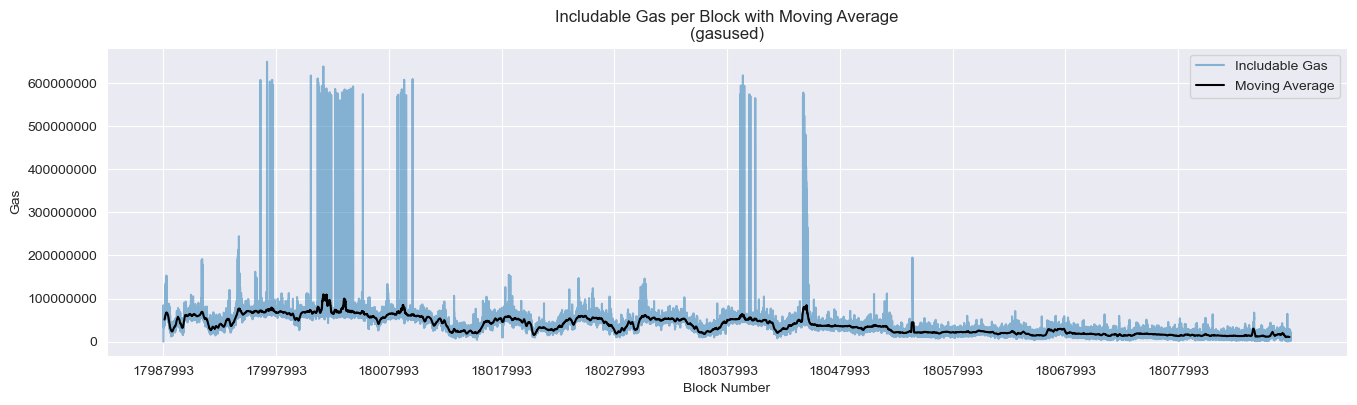

In [31]:
# Calculate the rolling mean
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=200, center=True).mean()

sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

plt.plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha = 0.5)
plt.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

plt.title('Includable Gas per Block with Moving Average\n(gasused)')
plt.xlabel('Block Number')
plt.ylabel('Gas')

plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')

plt.legend()

plt.show()

### Includable Gas per Block using 'gasused' with Moving Average, zoomed in to see the moving average

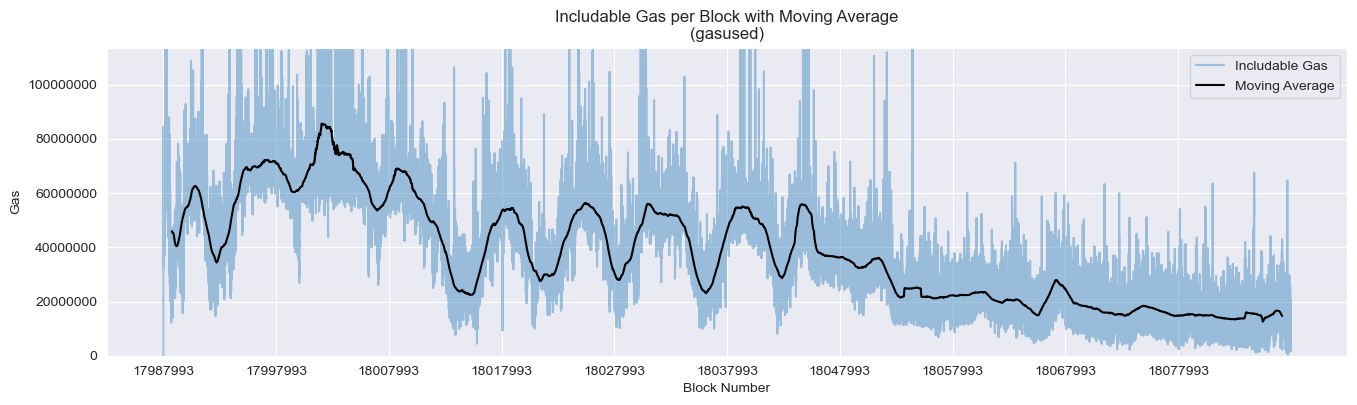

In [30]:
#ZOOM!

includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=1500, center=True).mean()

sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

plt.plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha=0.4)
plt.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

plt.title('Includable Gas per Block with Moving Average\n(gasused)')
plt.xlabel('Block Number')
plt.ylabel('Gas')

plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')

ymin, ymax = plt.ylim()
plt.ylim(0, ymax/6)
# plt.ylim(0, 175000000)

plt.legend()

plt.show()

### Plot the last two plots side-by-side
Note they are the same plot. The lower one is just 'zoomed in'

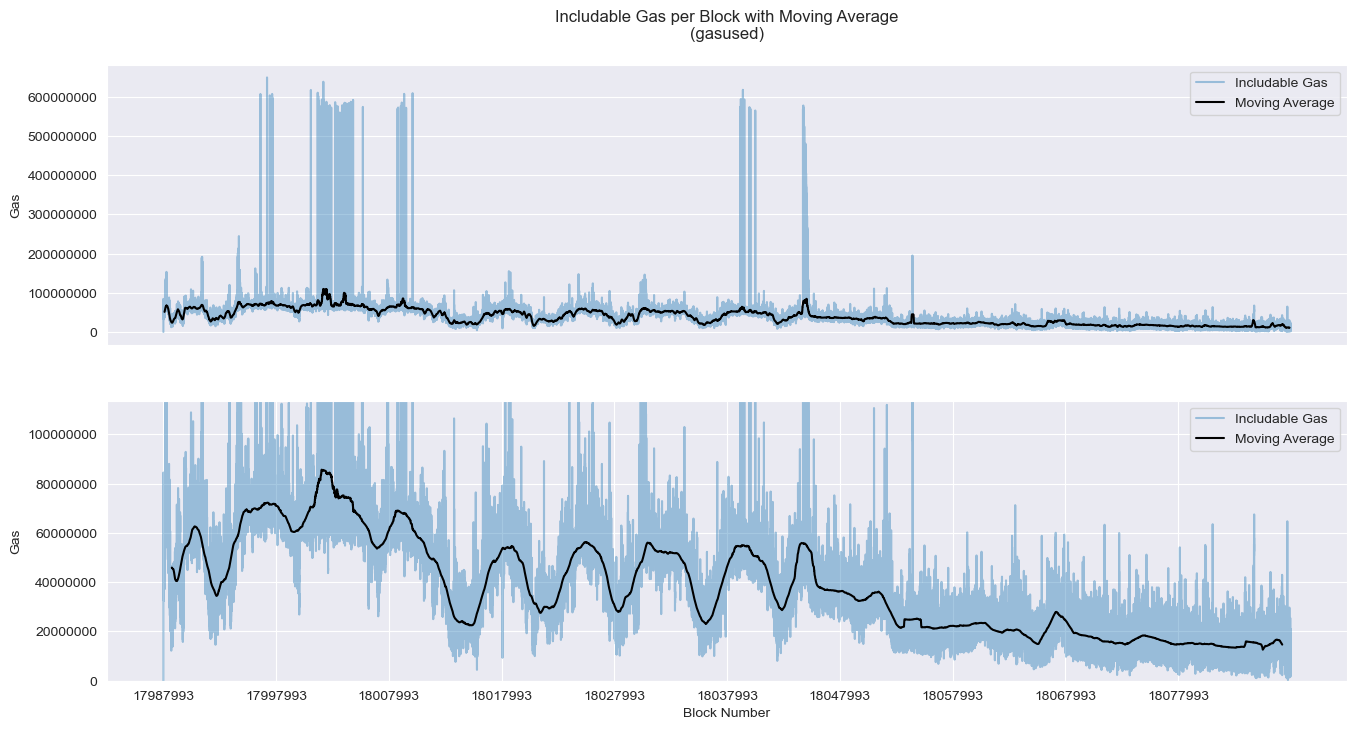

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# First plot
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=200, center=True).mean()

sns.set_style('darkgrid')

axs[0].plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha = 0.4)
axs[0].plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

axs[0].set_title('Includable Gas per Block with Moving Average\n(gasused)\n')
axs[0].set_ylabel('Gas')

axs[0].set_xticks([])
axs[0].ticklabel_format(style='plain')

axs[0].legend()

# Second plot
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=1500, center=True).mean()

axs[1].plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha=0.4)
axs[1].plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

axs[1].set_xlabel('Block Number')
axs[1].set_ylabel('Gas')

axs[1].set_xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
axs[1].ticklabel_format(style='plain')

# axs[1].set_ylim(0, 175000000)
ymin, ymax = axs[1].get_ylim()
axs[1].set_ylim(0, ymax/6)

axs[1].legend()
axs[1].legend(loc='upper right')

plt.show()

### Includable gas and txn count

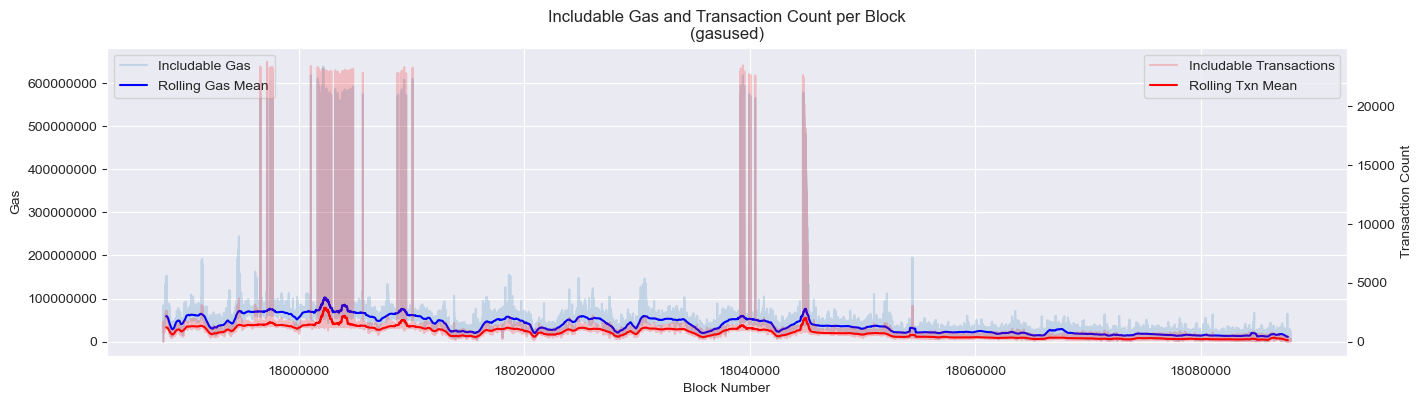

In [35]:
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=500, center=True).mean()

fig, ax1 = plt.subplots(figsize=(16, 4))

sns.set_style('darkgrid', {'axes.grid': False})

ax1.plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha = 0.2)
ax1.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Rolling Gas Mean', color='blue')

ax1.set_title('Includable Gas and Transaction Count per Block\n(gasused)')
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Gas')

ax1.ticklabel_format(style='plain')

ax1.legend(loc='upper left')


# Plot the 'Txn Count' on the second y-axis
ax2 = ax1.twinx()

includable_df['Rolling Mean txns'] = includable_df['TXNS'].rolling(window=500, center=True).mean()

ax2.plot(includable_df['Block'], includable_df['TXNS'], label='Includable Transactions', color='red', alpha=0.2)
ax2.plot(includable_df['Block'], includable_df['Rolling Mean txns'], label='Rolling Txn Mean', color='red')

ax2.set_ylabel('Transaction Count')
ax2.legend(loc='upper right')

plt.show()

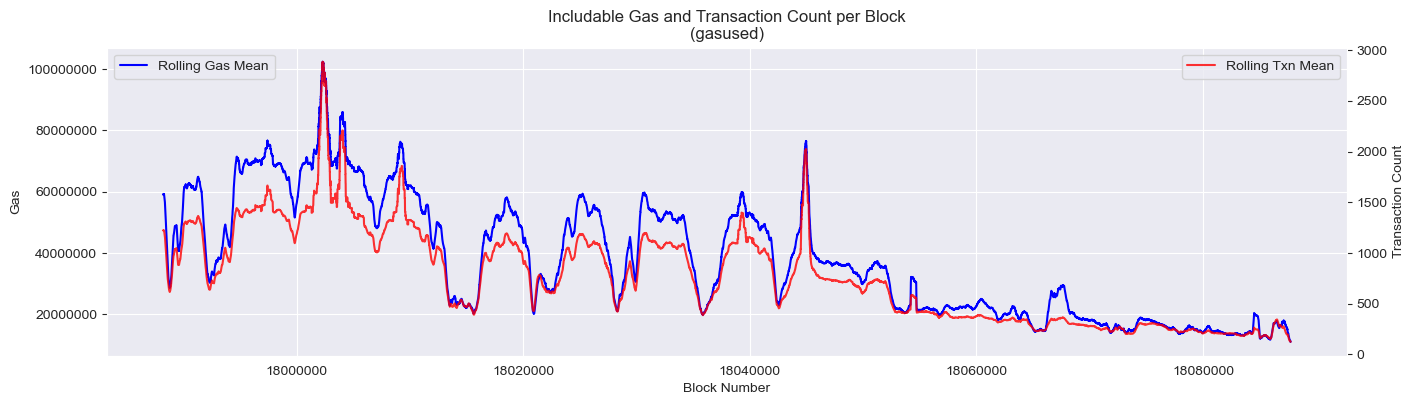

In [53]:
# zoom!

includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=500, center=True).mean()

fig, ax1 = plt.subplots(figsize=(16, 4))

sns.set_style('darkgrid', {'axes.grid': False})

# ax1.plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha = 0.2)
ax1.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Rolling Gas Mean', color='blue')

ax1.set_title('Includable Gas and Transaction Count per Block\n(gasused)')
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Gas')

ax1.ticklabel_format(style='plain')

ax1.legend(loc='upper left')

# ymin, ymax = ax1.get_ylim()
# ax1.set_ylim(0, ymax/5)


# Plot the 'Txn Count' on the second y-axis
ax2 = ax1.twinx()

includable_df['Rolling Mean txns'] = includable_df['TXNS'].rolling(window=500, center=True).mean()

# ax2.plot(includable_df['Block'], includable_df['TXNS'], label='Includable Transactions', color='red', alpha=0.1
ax2.plot(includable_df['Block'], includable_df['Rolling Mean txns'], label='Rolling Txn Mean', color='red', alpha=0.8)

ax2.set_ylabel('Transaction Count')
ax2.legend(loc='upper right')

# ymin, ymax = ax2.get_ylim()
# ax2.set_ylim(0, ymax/8)

plt.show()

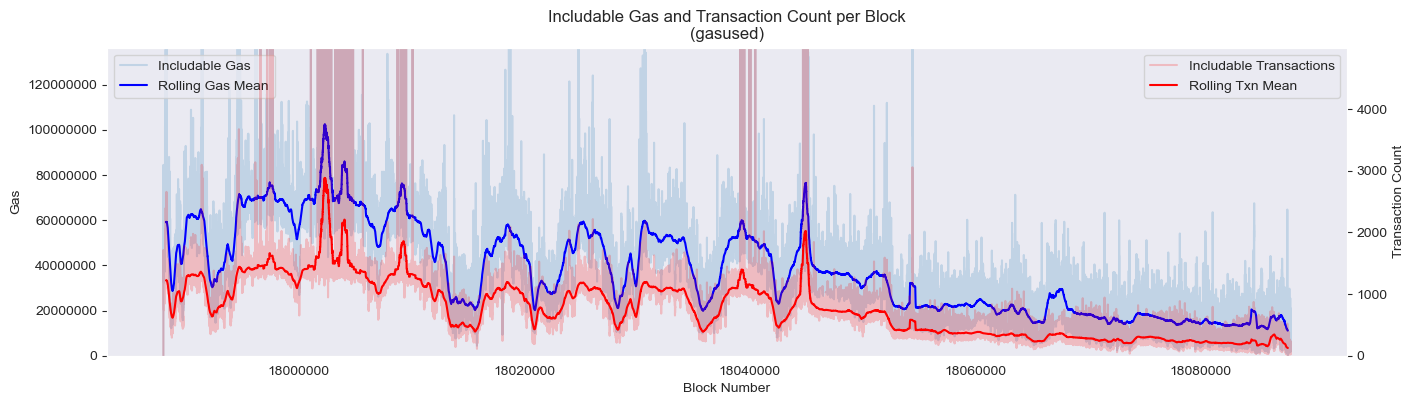

In [41]:
# zoom!

includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=500, center=True).mean()

fig, ax1 = plt.subplots(figsize=(16, 4))

sns.set_style('darkgrid', {'axes.grid': False})

ax1.plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha = 0.2)
ax1.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Rolling Gas Mean', color='blue')

ax1.set_title('Includable Gas and Transaction Count per Block\n(gasused)')
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Gas')

ax1.ticklabel_format(style='plain')

ax1.legend(loc='upper left')

ymin, ymax = ax1.get_ylim()
ax1.set_ylim(0, ymax/5)


# Plot the 'Txn Count' on the second y-axis
ax2 = ax1.twinx()

includable_df['Rolling Mean txns'] = includable_df['TXNS'].rolling(window=500, center=True).mean()

ax2.plot(includable_df['Block'], includable_df['TXNS'], label='Includable Transactions', color='red', alpha=0.2)
ax2.plot(includable_df['Block'], includable_df['Rolling Mean txns'], label='Rolling Txn Mean', color='red')

ax2.set_ylabel('Transaction Count')
ax2.legend(loc='upper right')

ymin, ymax = ax2.get_ylim()
ax2.set_ylim(0, ymax/5)

plt.show()

### What if we only look at the last third of the data? Is it more normal??

In [19]:
df_len = len(includable_df)
includable_df_2 = includable_df.loc[df_len//1.5:]

In [22]:
print("{:,}".format(1.808210e+07))

18,082,100.0


In [21]:
includable_df_2['GUPB'].describe()

count    3.333200e+04
mean     1.808210e+07
std      6.145425e+06
min      2.716230e+05
25%      1.381337e+07
50%      1.728126e+07
75%      2.138294e+07
max      7.124228e+07
Name: GUPB, dtype: float64

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_36165/184530386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  includable_df_2['Rolling Mean'] = includable_df_2['GUPB'].rolling(window=500, center=True).mean()
/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_36165/184530386.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  includable_df_2['Rolling Mean txns'] = includable_df_2['TXNS'].rolling(window=500, center=True).mean()


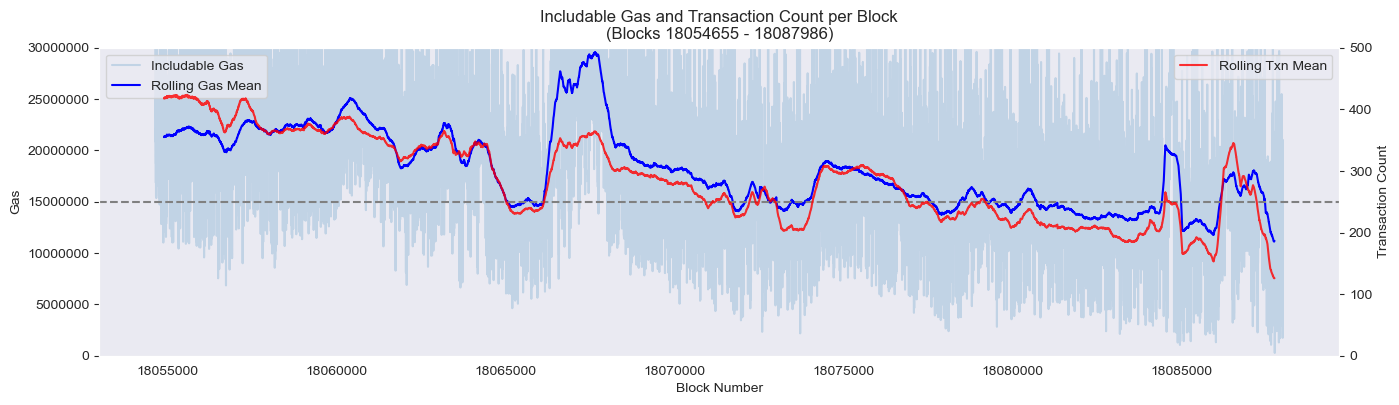

In [67]:
# Plot the last 1/3 of the data

includable_df_2['Rolling Mean'] = includable_df_2['GUPB'].rolling(window=500, center=True).mean()

fig, ax1 = plt.subplots(figsize=(16, 4))

sns.set_style('darkgrid', {'axes.grid': False})

ax1.plot(includable_df_2['Block'], includable_df_2['GUPB'], label='Includable Gas', alpha = 0.2)
ax1.plot(includable_df_2['Block'], includable_df_2['Rolling Mean'], label='Rolling Gas Mean', color='blue')

ax1.set_title('Includable Gas and Transaction Count per Block\n(Blocks '+str(includable_df_2['Block'].min()) + ' - ' + str(includable_df_2['Block'].max())+')')
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Gas')

ax1.ticklabel_format(style='plain')

ax1.legend(loc='upper left')

ymin, ymax = ax1.get_ylim()
# ax1.set_ylim(0, ymax/2)
ax1.set_ylim(0, 30000000)

# Add a horizontal dashed line at y = 15,000,000
ax1.axhline(15000000, color='grey', linestyle='--')

# Plot the 'Txn Count' on the second y-axis
ax2 = ax1.twinx()

includable_df_2['Rolling Mean txns'] = includable_df_2['TXNS'].rolling(window=500, center=True).mean()

# ax2.plot(includable_df_2['Block'], includable_df_2['TXNS'], label='Includable Transactions', color='red', alpha=0.2)
ax2.plot(includable_df_2['Block'], includable_df_2['Rolling Mean txns'], label='Rolling Txn Mean', color='red', alpha = 0.8)

ax2.set_ylabel('Transaction Count')
ax2.legend(loc='upper right')

# ymin, ymax = ax2.get_ylim()
ax2.set_ylim(0, 500)

plt.show()

### Includable Transaction Count per Block

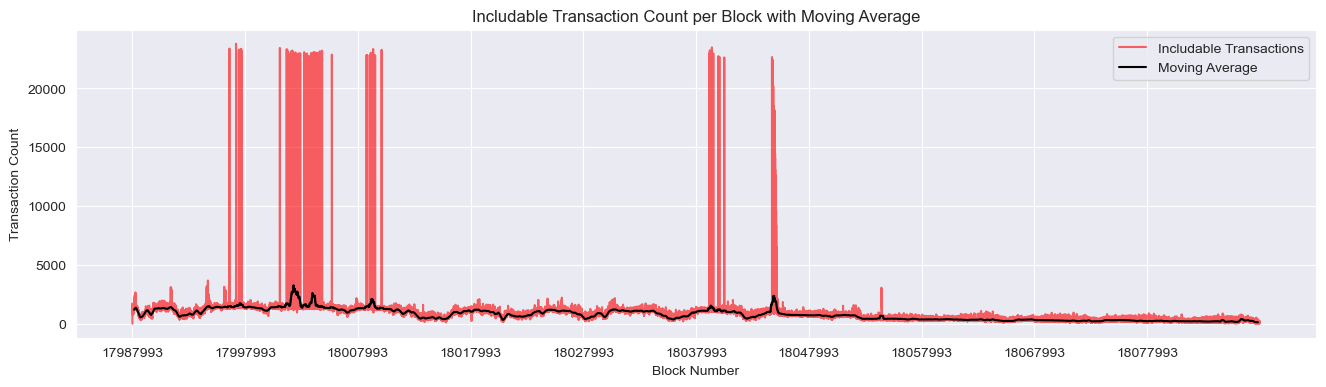

In [68]:
# # Calculate the rolling mean
includable_df['Rolling Mean'] = includable_df['TXNS'].rolling(window=300, center=True).mean()

sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

plt.plot(includable_df['Block'], includable_df['TXNS'], label='Includable Transactions', color='red', alpha=0.6)
plt.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

plt.title('Includable Transaction Count per Block with Moving Average')
plt.xlabel('Block Number')
plt.ylabel('Transaction Count')

plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')

plt.legend()


plt.show()

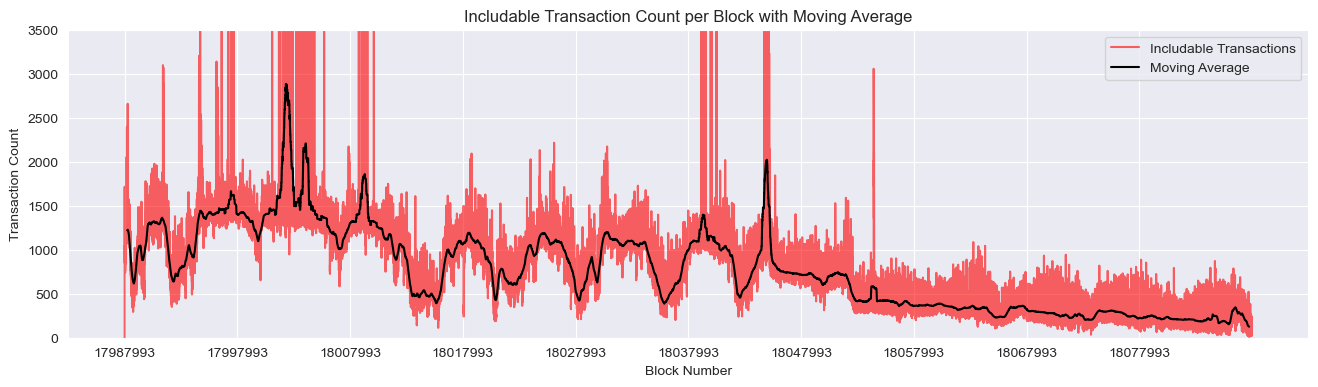

In [69]:
# Zoom! 
includable_df['Rolling Mean'] = includable_df['TXNS'].rolling(window=500, center=True).mean()

sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

plt.plot(includable_df['Block'], includable_df['TXNS'], label='Includable Transactions', color='red', alpha=0.6)
plt.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

plt.title('Includable Transaction Count per Block with Moving Average')
plt.xlabel('Block Number')
plt.ylabel('Transaction Count')

plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')

#set ylim 0 to 4000
plt.ylim(0, 3500)

plt.legend()


plt.show()

### Plot includable gas and txn counts side-by-side

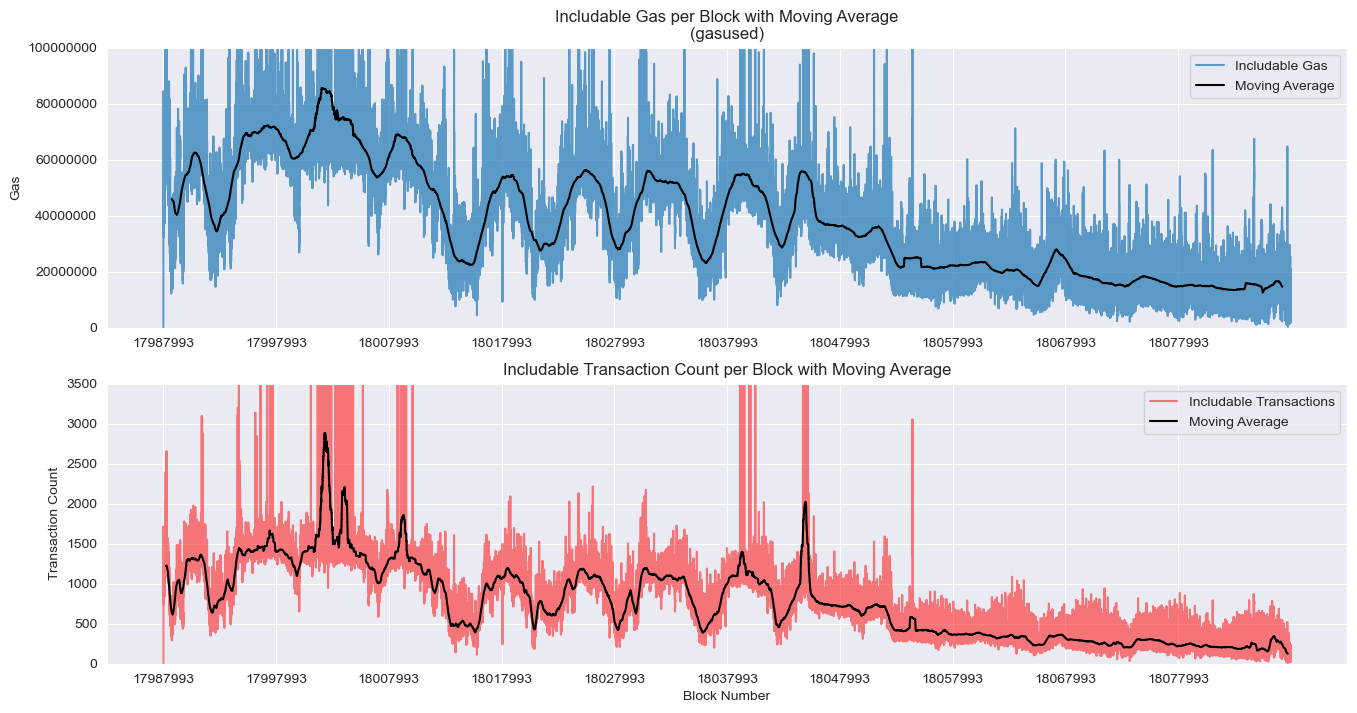

In [71]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# First plot
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=1500, center=True).mean()

sns.set_style('darkgrid')

axs[0].plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha=0.7)
axs[0].plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

axs[0].set_title('Includable Gas per Block with Moving Average\n(gasused)')
# axs[0].set_xlabel('Block Number')
axs[0].set_ylabel('Gas')

axs[0].set_xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
axs[0].ticklabel_format(style='plain')


axs[0].set_ylim(0, 100000000)
axs[0].legend(loc='upper right')
axs[0].legend()


# Second plot
includable_df['Rolling Mean'] = includable_df['TXNS'].rolling(window=500, center=True).mean()

axs[1].plot(includable_df['Block'], includable_df['TXNS'], label='Includable Transactions', color='red', alpha=0.5)
axs[1].plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

axs[1].set_title('Includable Transaction Count per Block with Moving Average')
axs[1].set_xlabel('Block Number')
axs[1].set_ylabel('Transaction Count')

axs[1].set_xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
axs[1].ticklabel_format(style='plain')

axs[1].set_ylim(0, 3500)

axs[1].legend()

# plt.tight_layout()
plt.show()

## Distributions

### Summary Stats

In [72]:
includable_df.describe()

,Block,GPB,GUPB,TXNS,Rolling Mean,Rolling Mean txns
count,9.999400e+04,9.999400e+04,9.999400e+04,99994.000000,99495.000000,99495.000000
mean,1.803799e+07,1.007610e+08,3.798321e+07,769.866862,770.473924,770.473924
std,2.886593e+04,5.432061e+07,2.766620e+07,909.716596,465.344235,465.344235
min,1.798799e+07,0.000000e+00,0.000000e+00,0.000000,125.792000,125.792000
25%,1.801299e+07,5.987535e+07,1.995404e+07,340.000000,344.898000,344.898000
50%,1.803799e+07,9.715245e+07,3.413245e+07,703.000000,716.758000,716.758000
75%,1.806299e+07,1.346231e+08,5.340497e+07,1107.000000,1098.839000,1098.839000
max,1.808799e+07,1.334805e+09,6.493091e+08,23793.000000,2884.738000,2884.738000


### Distribution of Includable Gas Per Block

How much gas is available to a builder to create a block?

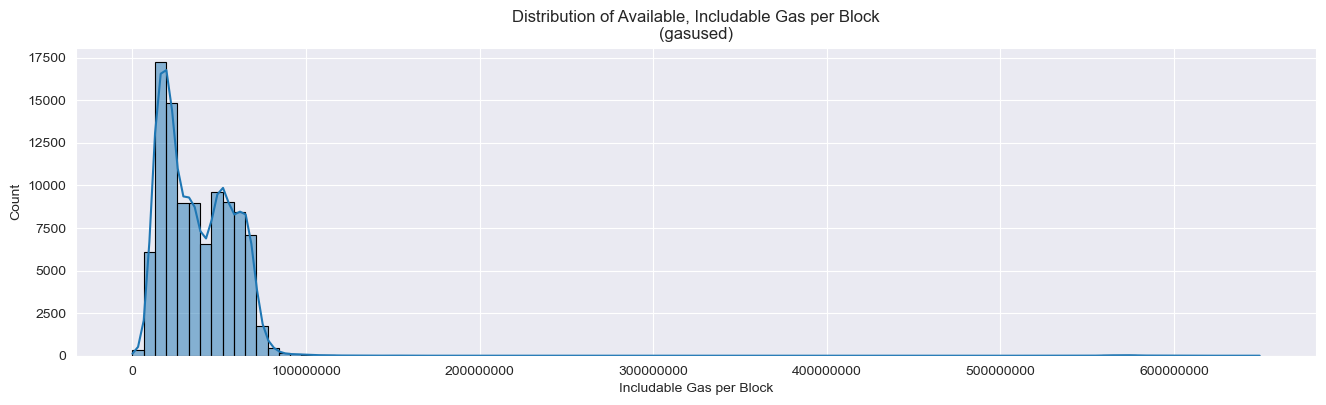

In [77]:
# plot the distribution of GUPB 
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))
sns.histplot(includable_df['GUPB'], bins=100, kde=True, edgecolor='black')
plt.title('Distribution of Available, Includable Gas per Block\n(gasused)')
plt.ticklabel_format(style='plain')
plt.xlabel('Includable Gas per Block')
plt.show()

### Distribution of Includable Gas Per Block zoomed in with auto bins

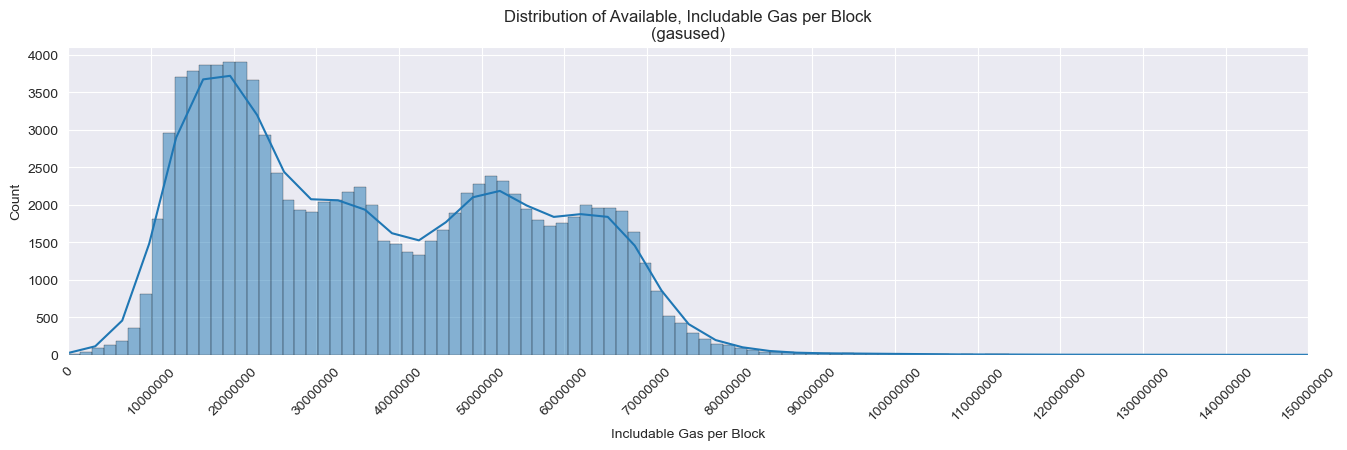

In [82]:
# zoom! 
plt.figure(figsize=(16, 4))

sns.histplot(includable_df['GUPB'], bins='auto', kde=True, edgecolor = 'black')
plt.title('Distribution of Available, Includable Gas per Block\n(gasused)')

plt.xticks(np.arange(0, includable_df['GUPB'].max(), 10000000), rotation=45)
plt.xlim(0, 150000000)
plt.xlabel('Includable Gas per Block')
plt.ticklabel_format(style='plain')
plt.show()

### Distribution of Includable Transactions (count) Per Block 
How many includable transactions are available to a builder 

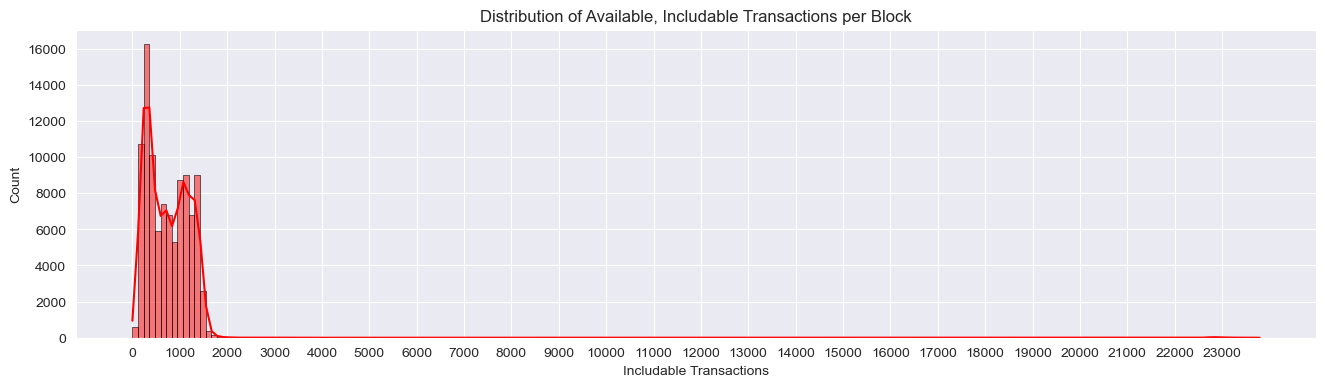

In [79]:
# plot the distribution of txn count per block 
plt.figure(figsize=(16, 4))
sns.histplot(includable_df['TXNS'], bins = 200, kde=True, edgecolor='black', color = 'red')
plt.title('Distribution of Available, Includable Transactions per Block')
plt.ticklabel_format(style='plain')
# xticks every 100 
plt.xticks(np.arange(0, includable_df['TXNS'].max(), 1000))
plt.xlabel('Includable Transactions')
plt.show()

#### increase bins (use auto) and zoom in to investigate distribution of blocks with <2500 transactions

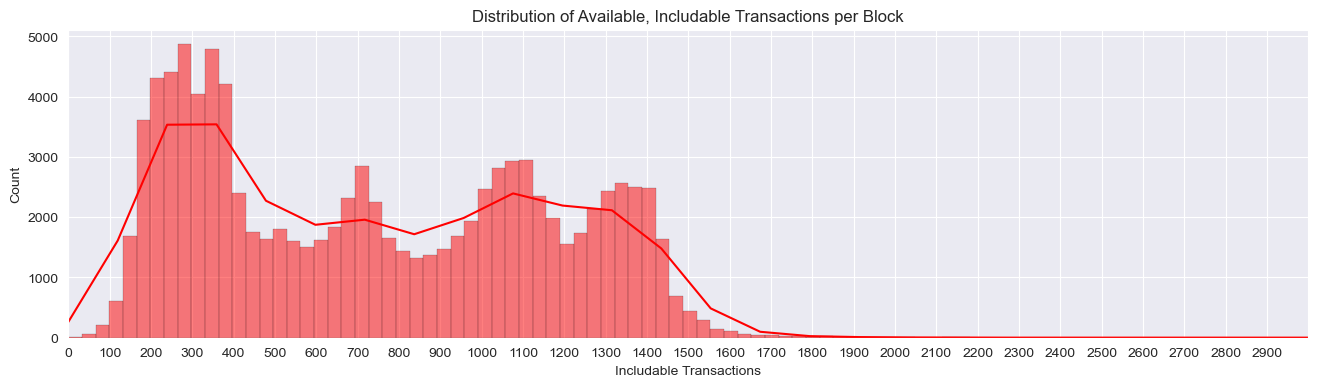

In [87]:
# plot the distribution of txn count per block 
plt.figure(figsize=(16, 4))
sns.histplot(includable_df['TXNS'], bins='auto', kde=True, edgecolor='black', color = 'red')
plt.title('Distribution of Available, Includable Transactions per Block')
plt.ticklabel_format(style='plain')
plt.xlabel('Includable Transactions')
plt.xticks(np.arange(0, 3000, 100))
plt.xlim(0, 3000)
plt.show()

## Distributions for last 1/3 of data

In [83]:
includable_df_2.describe()

,Block,GPB,GUPB,TXNS,Rolling Mean,Rolling Mean txns
count,3.333200e+04,3.333200e+04,3.333200e+04,33332.000000,3.283300e+04,32833.000000
mean,1.807132e+07,5.814852e+07,1.808210e+07,285.703588,1.811015e+07,285.962615
std,9.622264e+03,3.075226e+07,6.145425e+06,96.316300,3.784895e+06,68.074618
min,1.805466e+07,4.005140e+05,2.716230e+05,8.000000,1.112344e+07,125.792000
25%,1.806299e+07,3.989387e+07,1.381337e+07,215.000000,1.485122e+07,229.408000
50%,1.807132e+07,5.305181e+07,1.728126e+07,278.000000,1.752995e+07,281.096000
75%,1.807965e+07,6.901749e+07,2.138294e+07,347.000000,2.133212e+07,343.626000
max,1.808799e+07,6.000803e+08,7.124228e+07,1087.000000,2.956757e+07,423.586000


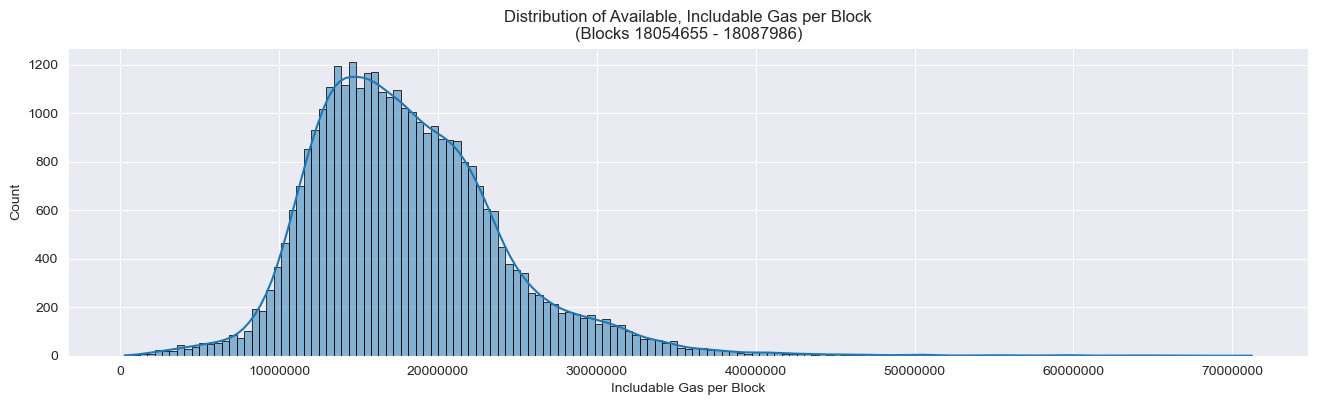

In [90]:
# zoom! 
plt.figure(figsize=(16, 4))

sns.histplot(includable_df_2['GUPB'], bins='auto', kde=True, edgecolor = 'black')
plt.title('Distribution of Available, Includable Gas per Block\n(Blocks '+str(includable_df_2['Block'].min()) + ' - ' + str(includable_df_2['Block'].max())+')')

# plt.xticks(np.arange(0, includable_df_2['GUPB'].max(), 10000000), rotation=45)
# plt.xlim(0, 150000000)
plt.xlabel('Includable Gas per Block')
plt.ticklabel_format(style='plain')
plt.show()

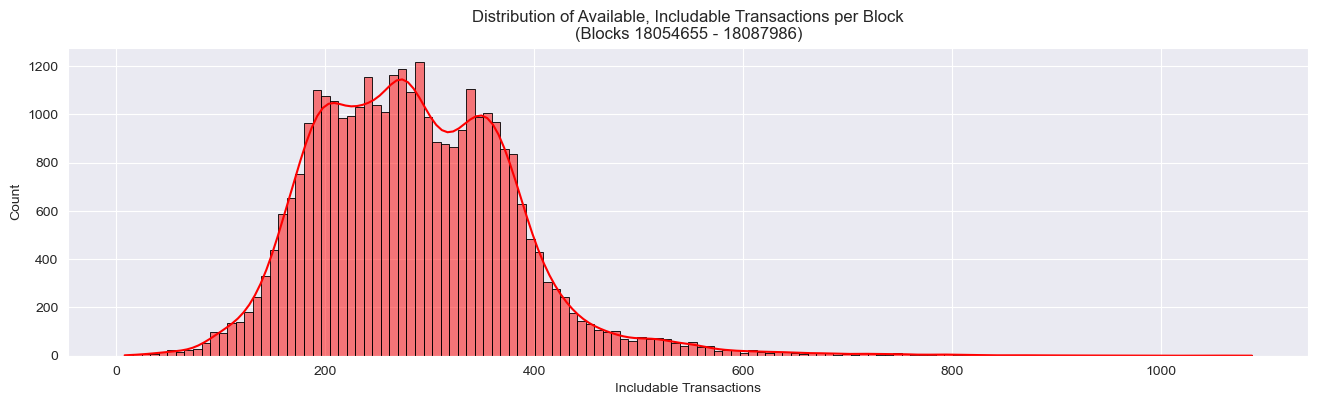

In [89]:
# plot the distribution of txn count per block 
plt.figure(figsize=(16, 4))
sns.histplot(includable_df_2['TXNS'], bins='auto', kde=True, edgecolor='black', color = 'red')
plt.title('Distribution of Available, Includable Transactions per Block\n(Blocks '+str(includable_df_2['Block'].min()) + ' - ' + str(includable_df_2['Block'].max())+')')
plt.ticklabel_format(style='plain')
plt.xlabel('Includable Transactions')
# plt.xticks(np.arange(0, 3000, 100))
# plt.xlim(0, 3000)
plt.show()